<a href="https://colab.research.google.com/github/slagathorr/cvdb/blob/main/CVDB_with_DuckDB_and_MotherDuck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Go [here](https://colab.research.google.com/drive/10MwbXWorAXUQNTS3DwOPTqnDR6Sp52Va?authuser=2#scrollTo=KS59w7GzVevX) if you want to see the original notebook with everything running on a local DuckDB database. This notebook is the same, except the connection string connects to MotherDuck instead.



---



As a thought experiment, we thought we would see how easy or difficult it will be to take the [Open CVDB](https://github.com/wiz-sec/open-cvdb) files and load them into DuckDB to do some quick analysis. The source files are a series of YAML files ([located here](https://github.com/wiz-sec/open-cvdb/tree/main/vulnerabilities)) that we need to shoehorn into the database.

Spoiler alert, turns out it's pretty easy.

# Setup

This uses PyYAML, but it's already installed with Colab.

This uses DuckDB, but it's already installed with Colab.

In [1]:
# Fetch the files.

!rm -rf /my_computer
!git clone https://github.com/wiz-sec/open-cvdb.git /my_computer
!mkdir  /my_computer/vulnerabilities_json/

Cloning into '/my_computer'...
remote: Enumerating objects: 2391, done.
remote: Counting objects: 100% (2391/2391), done.
remote: Compressing objects: 100% (987/987), done.
remote: Total 2391 (delta 1461), reused 2291 (delta 1385), pack-reused 0
Receiving objects: 100% (2391/2391), 35.74 MiB | 33.24 MiB/s, done.
Resolving deltas: 100% (1461/1461), done.


In [2]:
# Hit the library.

import yaml
import json
import os
from google.colab import data_table

data_table.enable_dataframe_formatter()

Let's process the files and convert them to JSON.

In [3]:
# Iterate through the YAML files, read them into a native Python data type, and write out JSON.

for filename in os.listdir('/my_computer/vulnerabilities/'):
  filename_yaml = "/my_computer/vulnerabilities/" + filename
  print("Starting: ", filename)
  filename_json = "/my_computer/vulnerabilities_json/" + filename.replace("yaml", "json")
  with open(filename_yaml, 'r') as yaml_in, open(filename_json, "w") as json_out:
    yaml_object = yaml.safe_load(yaml_in) # yaml_object will be a list or a dict
    json.dump(yaml_object, json_out)
  print("Wrote: ", filename_json)

Starting:  gcp-2021-019.yaml
Wrote:  /my_computer/vulnerabilities_json/gcp-2021-019.json
Starting:  cve-2019-1372.yaml
Wrote:  /my_computer/vulnerabilities_json/cve-2019-1372.json
Starting:  gcp-cloudshell-xss-csrf.yaml
Wrote:  /my_computer/vulnerabilities_json/gcp-cloudshell-xss-csrf.json
Starting:  extrareplica.yaml
Wrote:  /my_computer/vulnerabilities_json/extrareplica.json
Starting:  aws-s3-recon-account-id-of-bucket.yaml
Wrote:  /my_computer/vulnerabilities_json/aws-s3-recon-account-id-of-bucket.json
Starting:  gce_ssh_key_injection.yaml
Wrote:  /my_computer/vulnerabilities_json/gce_ssh_key_injection.json
Starting:  cloudsql-privesc.yaml
Wrote:  /my_computer/vulnerabilities_json/cloudsql-privesc.json
Starting:  aws-appsync-confused-deputy.yaml
Wrote:  /my_computer/vulnerabilities_json/aws-appsync-confused-deputy.json
Starting:  bastion-container-reg-xss.yaml
Wrote:  /my_computer/vulnerabilities_json/bastion-container-reg-xss.json
Starting:  bluebleed.yaml
Wrote:  /my_computer/vuln

# DuckDB Time!

Let's first take a look at a file and see what they look like.

In [4]:
!cat /my_computer/vulnerabilities/autowarp.yaml

title: AutoWarp
slug: autowarp
cves: null
affectedPlatforms:
- Azure
affectedServices:
- Automation Service
image: https://images.unsplash.com/photo-1651491602333-fea83f1d9107?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80
severity: Critical
piercingIndexVector: {version: 1.5, A1: 20, A2: 1.21, A7: 1.1, A8: 1.1}
discoveredBy:
  name: Yanir Tsarimi
  org: Orca Security
  domain: https://orca.security/
  twitter: null
publishedAt: 2022/03/07
disclosedAt: 2021/12/06
exploitabilityPeriod: null
knownITWExploitation: false
summary: |
  An exposed endpoint in the Azure Automation Service allowed to steal Azure
  API credentials from other customers
manualRemediation: |
  None required. As a general practice, use the least-privilege
  principle, including on managed identities assigned to automation accounts. While
  this would not have prevented the leakage of API credentials, it would have reduced
  the blast radius.
detectionMethods: null
c

## Let's fetch a duck!

## Create and load table

Load up a DuckDB instance, and start digging.

We are manually defining a schema because while the structure is consistent, the data values are necessarily not. As an example, there are instances where the `knownITWExploitation` field is set to a `STRING` of "No" and others where it's a `BOOL` of `false`. The auto detect functions would set this as a `BOOL` and error out when it hit strings. There are other data types like that as well.

### MotherDuck Change

Note: This is the section that changed. Be sure to sign up for MotherDuck [here](https://motherduck.com/docs/category/getting-started/), and [get your service token](https://motherduck.com/docs/authenticating-to-motherduck#fetching-the-service-token). Enter it when you're prompted here. If it is successful, you should be able to see the new database when you log into MotherDuck. Everything else should be the same in this notebook, except it is now using this remote connection.
  

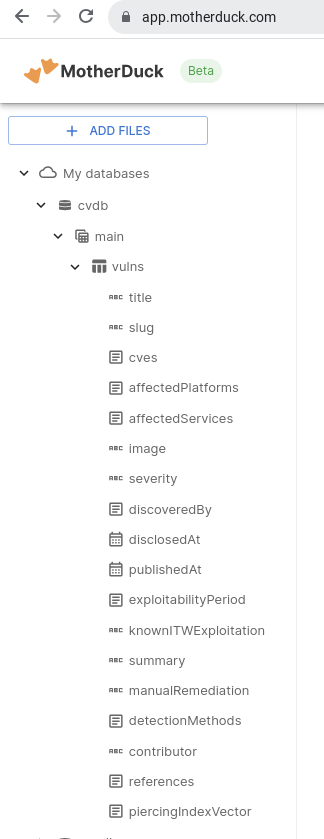

In [5]:
from google.colab import userdata
import duckdb

from getpass import getpass
md_token = getpass('Enter your MotherDuck token here: ')

database = 'cvdb'
conn_string = 'md:' + database + '?motherduck_token=' + md_token
conn = duckdb.connect(conn_string)

conn.execute("""
CREATE OR REPLACE TABLE vulns AS (
  SELECT * FROM READ_JSON_AUTO('/my_computer/vulnerabilities_json/*.json', columns={
    title:  'VARCHAR',
    slug:   'VARCHAR',
    cves:   'VARCHAR[]',
    affectedPlatforms:  'VARCHAR[]',
    affectedServices:   'VARCHAR[]',
    image:  'VARCHAR',
    severity:           'VARCHAR',
    discoveredBy:       'STRUCT(name VARCHAR, org VARCHAR, domain VARCHAR, twitter JSON)',
    disclosedAt:        'DATE',
    publishedAt:        'DATE',
    exploitabilityPeriod:   'JSON',
    knownITWExploitation:   'VARCHAR',
    summary:            'VARCHAR',
    manualRemediation:  'VARCHAR',
    detectionMethods:   'JSON',
    contributor:        'VARCHAR',
    "references":       'VARCHAR[]',
    piercingIndexVector:  'STRUCT(version DOUBLE, A1 BIGINT, A2 DOUBLE, A7 DOUBLE, A8 DOUBLE)'
    }, ignore_errors=true
                        ));
""")

conn.execute("""
DESCRIBE vulns;
""").fetchdf()

Enter your MotherDuck token here: ··········


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,NaN
1,slug,VARCHAR,YES,None,None,NaN
2,cves,VARCHAR[],YES,None,None,NaN
3,affectedPlatforms,VARCHAR[],YES,None,None,NaN
4,affectedServices,VARCHAR[],YES,None,None,NaN
5,image,VARCHAR,YES,None,None,NaN
6,severity,VARCHAR,YES,None,None,NaN
7,discoveredBy,"STRUCT(""name"" VARCHAR, org VARCHAR, ""domain"" V...",YES,None,None,NaN
8,disclosedAt,DATE,YES,None,None,NaN
9,publishedAt,DATE,YES,None,None,NaN


## Verify

In [6]:
# Let's see the data.

conn.execute("SELECT * FROM vulns LIMIT 3").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,FabricScape (CVE-2022-30137) - Azure Service F...,CVE-2022-30137,[cve-2022-30137],[Azure],[Service Fabric],https://raw.githubusercontent.com/wiz-sec/open...,Medium,"{'name': 'Aviv Sasson', 'org': 'Palo Alto Netw...",2022-06-14,2022-06-28,"""until 2022/05/24""",false,A vulnerability in Service Fabric allows Linux...,Users can check their current Service Fabric v...,"""Linux Service Fabric runtime < 9.0.1035.1""",https://github.com/leszekgrzegorek,[https://unit42.paloaltonetworks.com/fabricsca...,"{'version': 1.5, 'A1': None, 'A2': None, 'A7':..."
1,Multiple issues in AWS IAM Authenticator for K...,aws-auth-multiple-issues,NaN,[AWS],[EKS],https://cdn.pixabay.com/photo/2017/02/19/23/10...,Low,"{'name': 'Felix Wilhelm', 'org': 'Google', 'do...",2020-07-15,2020-10-06,None,false,Amazon Elastic Kubernetes Service (EKS) uses I...,None required\n,None,https://github.com/korniko98,[https://bugs.chromium.org/p/project-zero/issu...,NaN
2,Azure AD information disclosure via undocument...,azure-info-disclosure,NaN,[Azure],NaN,https://images.unsplash.com/photo-158676985283...,Low,"{'name': None, 'org': 'Secureworks', 'domain':...",2022-04-05,2022-04-05,None,No,Undocumented Azure AD APIs could allow access ...,None,None,https://github.com/ramimac,[https://www.secureworks.com/research/azure-ac...,NaN


In [10]:
# Quick verification to see if the previous YAML (autowarp) we looked at matches.

conn.execute("""
SELECT * FROM vulns
WHERE title = 'AutoWarp';
""").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,AutoWarp,autowarp,NaN,[Azure],[Automation Service],https://images.unsplash.com/photo-165149160233...,Critical,"{'name': 'Yanir Tsarimi', 'org': 'Orca Securit...",2021-12-06,2022-03-07,None,false,An exposed endpoint in the Azure Automation Se...,"None required. As a general practice, use the ...",None,https://github.com/christophetd,[https://orca.security/resources/blog/autowarp...,"{'version': 1.5, 'A1': 20, 'A2': 1.21, 'A7': 1..."


# Analysis Time!

It looks like it works! Let's ask some questions.



## How many vulnerabilities were disclosed per month?

<Axes: xlabel='month'>

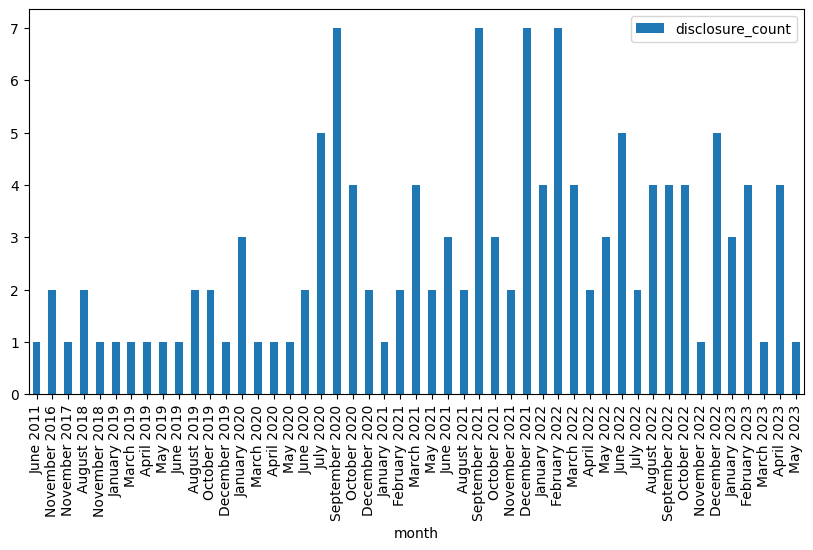

In [7]:
# How many vulnerabilities were disclosed per month?

results=conn.execute("""
SELECT
  count(*) AS disclosure_count,
  STRFTIME(DATE_TRUNC('month',disclosedAt),'%B %Y') AS month,
  DATE_TRUNC('month', disclosedAt) AS month_datetime
  FROM vulns
  WHERE month IS NOT NULL
  GROUP BY month_datetime
  ORDER BY month_datetime asc;
""").fetchdf()

results.plot(x="month", y="disclosure_count", kind="bar", figsize=(10, 5))

## Are there really disclosures with no disclosure times?

At the time of writing, we are finding that there are entires of `nan` on our histogram. Which makes us wonder, are there really disclosures that don't have time associated with them?

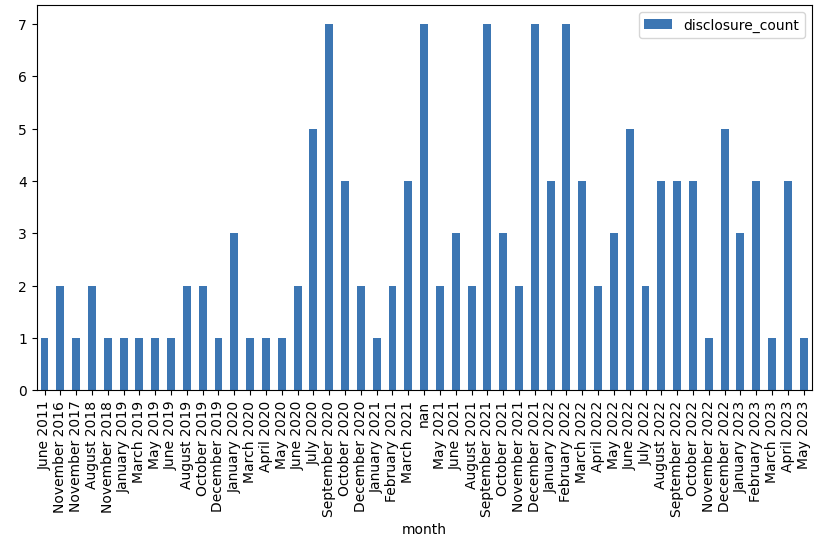

Let's see what the data actually looks like.

In [8]:
conn.execute("SELECT * FROM vulns WHERE disclosedat IS NULL").fetchdf()

,title,slug,cves,affectedPlatforms,affectedServices,image,severity,discoveredBy,disclosedAt,publishedAt,exploitabilityPeriod,knownITWExploitation,summary,manualRemediation,detectionMethods,contributor,references,piercingIndexVector
0,GCP Cloudshell Cross-Site WebSocket Hijacking ...,gcp-cloudshell-cswsh,NaN,[GCP],[GCP Cloudshell],https://images.unsplash.com/photo-1543789289-2...,Low,"{'name': 'Psi', 'org': None, 'domain': 'ψ.fun'...",NaT,2020-03-11,None,false,Google Cloudshell leveraged websockets without...,null\n,None,https://github.com/ramimac,"[https://ψ.fun/i/yvpMj, https://security.googl...",NaN
1,GCP Default compute account is project Editor,gcp-default-compute-account,NaN,[GCP],NaN,https://assets.website-files.com/6207f5adfd8e6...,Medium,NaN,NaT,2020-11-22,"""Since the creation of GCP""",false,When the compute API is enabled on a GCP Proje...,"Remove these permissions, it can be done via a...",None,https://github.com/louisdurufle,[https://cloud.google.com/resource-manager/doc...,NaN
2,GKE Sandbox side channel attack,gcp-2022-011,NaN,[GCP],[GKE Sandbox],https://images.pexels.com/photos/5371573/pexel...,Medium,"{'name': None, 'org': None, 'domain': None, 't...",NaT,2022-03-22,None,None,There was a misconfiguration with Simultaneous...,Upgrade nodes to versions 1.22.6-gke.1500 and ...,None,https://github.com/ramimac,[https://cloud.google.com/support/bulletins#gc...,NaN
3,SSRF in Google Cloud Monitoring,ssrf-in-google-cloud-monitoring,NaN,[GCP],[Google Cloud Monitoring],https://images.unsplash.com/photo-159085602982...,Medium,"{'name': 'David Nechuta', 'org': None, 'domain...",NaT,2020-11-12,None,None,An SSRF bug in Google Cloud Monitoring's uptim...,None required\n,None,https://github.com/0xdabbad00,[https://nechudav.blogspot.com/2020/11/31k-ssr...,NaN
4,Bad.Build,badbuild,NaN,[GCP],[Cloud Build],https://raw.githubusercontent.com/wiz-sec/open...,Low,"{'name': 'Roi Nisimi', 'org': 'Orca Security',...",NaT,2023-07-18,None,false,An information disclosure vulnerability in the...,None required\n,None,https://github.com/korniko98,[https://cloud.google.com/build/docs/security-...,NaN
5,SNS SigningCertUrl improper validation,sns-signingcerturl-improper-validation,NaN,[AWS],[Amazon Simple Notification Service (SNS)],https://images.unsplash.com/photo-161109578012...,Medium,"{'name': 'Eugene Lim', 'org': None, 'domain': ...",NaT,2022-08-19,None,false,Amazon SNS' signature validation in the offici...,None required\n,None,https://github.com/ramimac,[https://spaceraccoon.dev/exploiting-improper-...,NaN
6,Azure App Service on Azure Stack Hub privilege...,cve-2023-21777,NaN,[Azure],[Azure App Service on Azure Stack Hub],https://raw.githubusercontent.com/wiz-sec/open...,Medium,"{'name': 'Ruslan Sayfiev, Denis Faiustov', 'or...",NaT,2023-02-14,None,false,A privilege escalation vulnerability was disco...,Users of Azure App Service on Azure Stack Hub ...,None,https://github.com/mer-b,[https://msrc.microsoft.com/update-guide/en-US...,NaN
7,Privilege escalation in GCP Cloud SQL,gcp-2023-007,NaN,[GCP],[Cloud SQL],https://images.unsplash.com/photo-1544383835-b...,Medium,"{'name': None, 'org': None, 'domain': None, 't...",NaT,2023-06-02,None,None,A vulnerability was discovered in Cloud SQL fo...,None required\n,None,https://github.com/ramimac,[https://cloud.google.com/support/bulletins#GC...,NaN
8,GCP Cloudshell XSS and CSRF bugs,gcp-cloudshell-xss-csrf,NaN,[GCP],[GCP Cloudshell],https://raw.githubusercontent.com/wiz-sec/open...,Medium,"{'name': 'Obmi', 'org': None, 'domain': 'https...",NaT,2019-12-15,None,false,GCP Cloudshell has been affected by various XS...,null\n,None,https://github.com/mer-b,[https://obmiblog.blogspot.com/2022/12/gcp-202...,NaN
9,Dropped active Google Cloud Armor security policy,gcp-2021-019,NaN,[GCP],[Cloud Armor],https://images.unsplash.com/photo-160721723722...,Low,"{'name': None, 'org': None, 'domain': None, 't...",NaT,2021-09-29,None,None,There is a known issue where updating a Backen...,Dropped Cloud Armor security po

Here we find that there are indeed instances where that is the case. On a side note, we also see that the `exploitabilityPeriod` field is also very much free form, which can make analysis of it somewhat of a challenge.

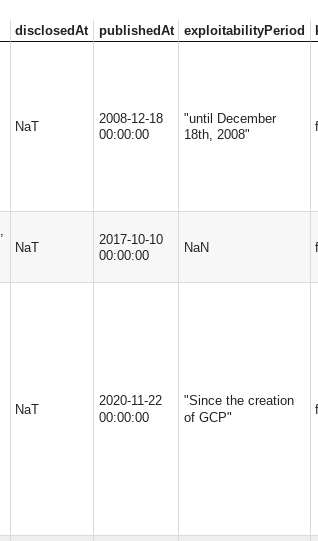

## How many vulnerabilities were published per month?

After chatting with a friend who knows security things more than I do, it looks like the publish date is going to be the one we really want to look at, and the data itself should be more complete. Let's try this one.

<Axes: xlabel='month'>

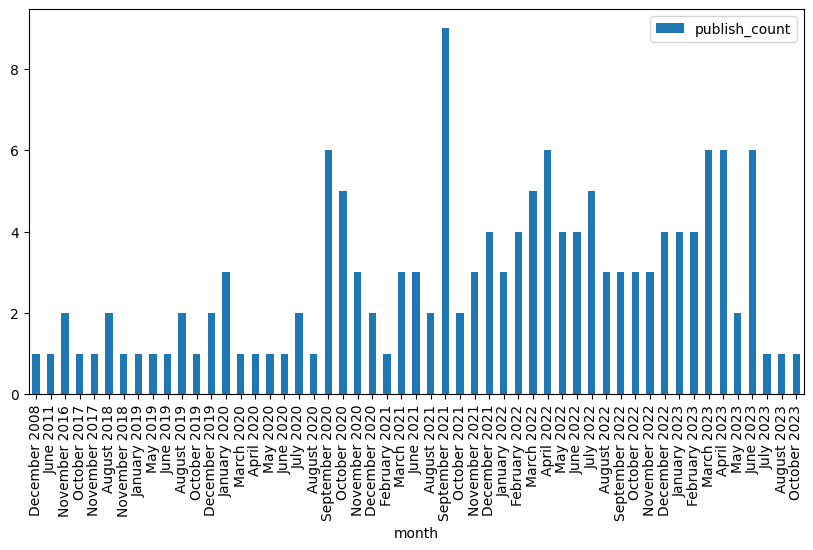

In [9]:
# How many vulnerabilities were published per month?

results=conn.execute("""
SELECT
  count(*) AS publish_count,
  STRFTIME(DATE_TRUNC('month',publishedAt),'%B %Y') AS month,
  DATE_TRUNC('month', publishedAt) AS month_datetime
  FROM vulns
  GROUP BY month_datetime
  ORDER BY month_datetime asc;
""").fetchdf()

results.plot(x="month", y="publish_count", kind="bar", figsize=(10, 5))

## What cloud platforms have the most vulnerabilities?

<Axes: ylabel='count'>

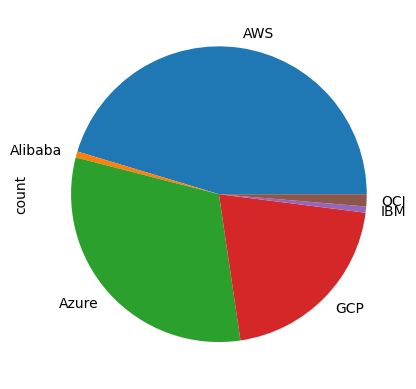

In [10]:
results=conn.execute("""
  WITH unnested_platforms AS (
    SELECT UNNEST(affectedPlatforms) AS cloud_platform
    FROM vulns)
  SELECT count(*) AS count, cloud_platform FROM unnested_platforms
  GROUP BY cloud_platform
""").fetchdf()

results.groupby(['cloud_platform']).sum().plot.pie(y="count", legend=None)

## What services have the most vulnerabilities?

Let's do the same thing with the services.

<Axes: xlabel='services'>

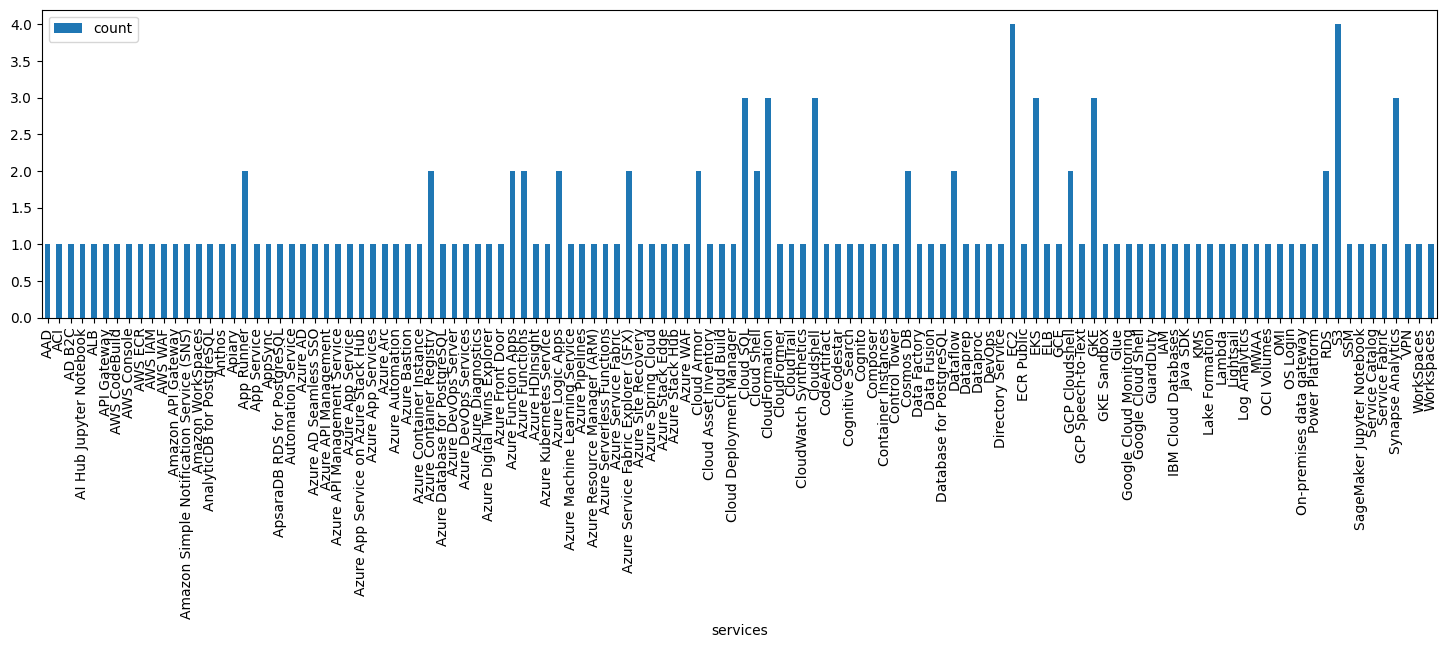

In [11]:
results=conn.execute("""
  WITH unnested_services AS (
    SELECT UNNEST(affectedServices) AS services
    FROM vulns)
  SELECT count(*) AS count, services FROM unnested_services
  GROUP BY services
  ORDER BY services ASC
""").fetchdf()

results.groupby(['services']).sum().plot.bar(y="count", figsize=(18, 4))